# Rnalib Introduction

The increasing abundance and complexity of biological data requires programatic approaches for their analysis that allow for the rapid development of custom yet efficient, well-tested and reproducible analysis pipelines. Traditional approaches (e.g., bash command/perl pipelines), that suffer from low readability, maintainability and reproducibility, are increasingly superseded by complex, containerized (e.g., docker/apptainer) analysis pipelines that combine specialized bioinformatics tools with custom scripts developed in higher programming languages such as *Python*, *R* or *Rust*.

Despite not being the fastest option, *Python* is a [popular choice by analysts](https://github.blog/2023-03-02-why-python-keeps-growing-explained/), mainly due to the large number of available (bioinformatics) libraries, its simple and well-documented syntax and its broad utility in the emerging data science field. For this reason, an increasing number of python APIs for the handling of genomics data are being developed. 
While some are mainly wrappers around well-established and efficient bioinformatics tools (e.g., pysam/samtools, pybedtools/BEDTools or cyvcf2/htslib), others are built on popular data wrangling/analysis libraries such as *pandas* or *numpy* (e.g., bioframe/pandas, pyranges/pandas, bionumpy/numpy).

Here, we present *_rnalib_*, a novel python library for handling genomics data with a focus on transcriptomics. _Rnalib_ is not meant to replace the existing (great) work of others but to complement and integrate it and to fill some missing gaps. It targets analysts and developers and its main design goals are to enable fast, readable, reproducible and robust development of novel bioinformatics methods.

At its core, _rnalib_ contains a transcriptome implementation that represents genomic features (such as genes, transcripts or exons) as python dataclasses and explicitly models their relationships. It provides a secure way for referencing and annotating such features by structuring them into immutable genomic locations (that can, e.g., safely be used in lookup tables) and mutable, arbitrary annotations. _rnalib_ implements various genomic iterators on top of existing python implementations (pysam, bioframe, pybedtools) for feature annotation and integration with biological data sources (e.g., gene/transcript annotations, sequence alignment data, genomic scores, etc.). Finally, _rnalib_ implements many different ways to analyse and export the annotated data, e.g., as pandas dataframes or 

This notebook presents the core API of rnalib:
* Its [transcriptome](#Transcriptome-implementation) implementation
* Its [genomic iterators](#Iterators) for efficient iteration over (subregions of) large-scaled genomics datasets based on the pysam library. Iterators keep track of the genomic region of the yielded data enabling their efficient integration with other genomics data
* Its strategies for genomic [feature annotation](#Feature-Annotation)
* and various [utility functions](#Utility-functions) for working with genomics data

We also provide a set of tutorials for demonstrating rnalib in realistic usage scenarios:
* [Tutorial: Read mismatch analysis](Tutorial_mismatch_analysis.ipynb)
* [Tutorial: Comparison of gene annotation sets](Tutorial_compare_annotation_sets.ipynb)
* [Tutorial: shRNA analysis](Tutorial_shRNA_analysis.ipynb)
* [Tutorial: Transcriptome analysis](Tutorial_transcriptome_annotation.ipynb)

We also [compare rnalib to a number of related APIs](RelatedWork_performance.ipynb) with regard to provided features and performance. We additionally demonstrate some common analysis pitfalls that we tried to address in the design of our library.

Finally, we showcase how the combination of (the strengths of) multiple genomics libraries leads to an overall benefit in multiple tutorials:
* [Tutorial: CTCF analysis with rnalib and bioframe](Tutorial_CTCF_analysis.ipynb)
* [Tutorial: Expression analysis with rnalib and genemunge](Tutorial_expression_analysis.ipynb)

For further API examples, please consider _rnalib_'s [test classes](https://github.com/popitsch/rnalib/tree/main/tests).

In [1]:
# install rnlib's requirements
#%pip install -r https://raw.githubusercontent.com/popitsch/rnalib/main/requirements.txt
# install additional requirements for this notebook
#%pip install biopython --upgrade
# import required libaries 
import os, pathlib, platform
import biotite.sequence as seq
from Bio.Align import PairwiseAligner
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import pysam
import numpy as np
import pprint
import pybedtools 
import bioframe
import tempfile
import pytest
import dataclasses
import arrow
import random
import itertools

# load rnalib
import rnalib as rna
from rnalib import gi, GI, SEP, display_textarea

display(f"Running rnalib {rna.__version__} on python {platform.python_version()}")
rna.__RNALIB_TESTDATA__ = "rnalib_testdata/"

import logging, sys
logging.basicConfig(stream=sys.stderr, level=logging.INFO)

'Running rnalib 0.0.2 on python 3.12.1'

## Test datasets

This notebook as well as _rnalib_'s testing suite use various test resources (genomics data files and indexing structures) that can be created by running the _rnalib_ `rnalib_create_testdata` script or by calling the `testdata.create_testdata()` method. Refer to `testdata.py` for details how the test data files were created.

There are two seperate test resource sets:

* *test_resources*: small test datasets that are used by _rnalib_'s test suite
* *large_test_resources*: larger test files that are needed to demonstrate rnalib under realistic conditions. 

_Rnalib_ knows about the location of the test data via the package-global __RNALIB_TESTDATA__ variable. This variable can either be set via the "RNALIB_TESTDATA" environment variable or by monkeypatching (rna.__RNALIB_TESTDATA__ = <mydir>) as shown below. Once this is done, test data resources can be accessed via 
`rna.get_resource(<resource_id>)`. _Rnalib_ will recreate these resources only if they are not found in the provided output folder.

In [2]:
if not os.path.isdir(rna.__RNALIB_TESTDATA__):
    os.mkdir(rna.__RNALIB_TESTDATA__)
    display("Creating testdata at {rna.__RNALIB_TESTDATA__ }")
    rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, rna.testdata.test_resources, show_data_dir=True)
else:
    display(f"Testdata in {rna.__RNALIB_TESTDATA__}")
    display_textarea('\n'.join(rna.dir_tree(pathlib.Path(rna.__RNALIB_TESTDATA__))))

'Testdata in rnalib_testdata/'

## Genomic intervals
At the heart of _rnalib_ is its representation of genomic regions (intervals), represented by the  *genomic intervals* (GI) class in _rnalib_:

In [3]:
display('GI documentation')
rna.display_textarea(rna.GI.__doc__, rows=10)

'GI documentation'

Here are some examples for instantiating and sorting genomic intervals:

In [4]:
# create a list of genomic intervals
locs=[gi('chr2', 1, 100), # chr2:1-100, unstranded
      gi('chr1:5-500 (+)'),  # parsed from string, strand='+'
      gi('chr3:50-120 (-)'), 
      gi('chr1:10-20 (-)'), 
      gi(None, None, 1000, '-'), # chromosome and start unbound, end=1000, strand='-'
      gi(None, 10, 1000, '-')] # chromosome unbound

# Properly sorting them requires knowledge about the order of the chromosomes
display('Sorting w/o reference dict leaves order of chromosomes undefined:', sorted(locs), SEP)

# Generally, the order of intervals from different groups (chromosomes) is left undefined.
display(f"The greater-than comparison chr2:1-1>chr1:1-1 is undefined: {gi('chr2', 1, 1) > gi('chr1', 1, 1)}", SEP)

# To sort also by chromosome, you can use a reference dict which defines the chromosome order:
refdict=rna.RefDict({'chr1':None, 'chr2':None, 'chr3':None}, 'test', None)
display(refdict, SEP)

# And then call the GI.sort(...) method which is basically returning 
# sorted(locs, key=lambda x: (refdict.index(x.chromosome), x))
display('Properly sorted list:', GI.sort(locs, refdict))

# Note that typically you don't need to do this as rnalib deals with bgzipped+tabixed files that are always 
# sorted and automatically derived reference dicts from the index. For manually created intervals or interval 
# sets derived via other sources that allow access to (potentially) unsorted files (e.g., rnalib), you can 
# use GI.sort() as shown above.

# Intervals with no defined chromosome (i.e., chromosome=None) will always be at the beginning of the list. 

# All intervals with start>end coordinate are considered 'empty'; internally, its coordinates are set to [0, -1].
empty_interval=gi('1',2,1)
display(SEP)

# Empty intervals have zero length
display(f"The length of empty interval is {len(empty_interval)}, the length of intervals w/o set start/end coordinates is defined as 2^31-1 (assuming int32): {len(gi())}")
display(f"Empty intervals do not overlap/do not envelop any interval including itself (overlap={empty_interval.overlaps(empty_interval)})")
display(f"Empty intervals are considered equal to any other empty interval on the same chromosome: ({empty_interval==gi('1',20,19)})...")
display(f"...but different from empty intervals on other chromosomes to not break chromsome order ({empty_interval==gi('2',20,19)})", SEP)

'Sorting w/o reference dict leaves order of chromosomes undefined:'

[None:0-1000 (-),
 chr2:1-100,
 chr1:5-500 (+),
 chr3:50-120 (-),
 chr1:10-20 (-),
 None:10-1000 (-)]

---

'The greater-than comparison chr2:1-1>chr1:1-1 is undefined: None'

---

RefDict (size: 3): dict_keys(['chr1', 'chr2', 'chr3']), dict_values([None, None, None]) name: test 

---

'Properly sorted list:'

[None:0-1000 (-),
 None:10-1000 (-),
 chr1:5-500 (+),
 chr1:10-20 (-),
 chr2:1-100,
 chr3:50-120 (-)]

---

'The length of empty interval is 0, the length of intervals w/o set start/end coordinates is defined as 2^31-1 (assuming int32): 2147483647'

'Empty intervals do not overlap/do not envelop any interval including itself (overlap=False)'

'Empty intervals are considered equal to any other empty interval on the same chromosome: (True)...'

'...but different from empty intervals on other chromosomes to not break chromsome order (False)'

---

## Transcriptome implementation
_rnalib_ provides a `transcriptome` implementation that enables convenient and efficient access/filtering of genomic annotations via python. 
Briefly, a (filtered) input GTF/GFF file is parsed and respective (frozen) dataclasses that derive from the generic `Feature` class are instantiated. 
The implementation keeps track of parent/child relationships (e.g., between genes, transcripts and their exons) and enables efficient iteration, querying and annotation. Data fields and annotations can conveniently be accessed via 'dot' notation (i.e., `<feature>.<attribute>`). 

Note that the current implementation does not implement the full GFF3 format as specified [here](https://github.com/The-Sequence-Ontology/Specifications/blob/master/gff3.md)
but currently rather supports various popular gff 'flavours' as published by _encode_, _ensembl_, _ucsc_, _chess_, _mirgenedb_ and _flybase_.
It also supports a 'generic' GFF3 format where all parsed features are interpreted as 'transcript' objects irrespecting the actual feature_type column.
Respective parent 'gene' annotations are automatically added, no sub-features (exons, introns, etc.) are created.

Here is a brief description of the datamodel depicted below:
-   Model contains `genes`, `transcripts` and arbitrary sub-features (e.g., `exons`, `introns`, 3'/5'-`UTR`s, `CDS`) as defined
    in the GFF file. Note that `intron` annotations are calculated automatically from exon annotations unless configured otherwise. 
    Frozen dataclasses (derived from the 'Feature' class) are created for all parsed feature types automatically and users may configure which 
    GTF/GFF attributes will be parsed and added to those dataclasses as fields.
    Gene intervals must envelop transcript intervals which must envelop sub-feature intervals.
    
-   A transcriptome maintains an `anno` dict that maps (frozen) features to dicts of arbitrary annotation values which supports the (incremental) annotation of annotation features. Annotation values can be accessed like GFF-parsed fields via 'dot' notation: `<feature>.<attribute>`. 
    
-   The implementation exploits the hierarchical relationship between genes and their sub-features to optimize storage and computational requirements where possible.        
    Genomic sequences, for example, can be loaded from a reference genome via load_sequence_datas() but will  be explicitly stored only for gene features. For sub-features (e.g., transcripts, exons, etc.) the respective sequence will be sliced from the gene sequence on demand. 
    
-   The get_sequence() method supports several modes:
    If `mode='rna'` is passed, the sequence is returned in 5'-3' orientation, i.e., they are reverse-complemented
    for minus-strand transcripts. The returned sequence will, however, still use the DNA alphabet (ACTG) to
    enable direct alignment/comparison with genomic sequences.
    if `mode='spliced'`, the spliced 5'-3' sequence will be returned.
    if `mode='translated'`, the spliced 5'-3' CDS sequence will be returned.
    
-   Genomic range queries via `query()` are supported by a combination of interval and linear search queries.
    A transcriptome object maintains one intervaltree per chromosome built from gene annotations.
    Overlap/envelop queries will first be applied to the respective intervaltree and the (typically small
    result sets) will then be filtered, e.g., for requested sub-feature types.
    
-   Transcriptome models can also be built from subsets of GFF/GTF files by filtering contained transcripts with a `TranscriptFilter()` that can restrict, e.g., included chromosomes, genomic regions, transcript_ids, gene_types or transcripts with certain 'tag' values (as used in gencode).

-   A transcriptome object keeps track of the numbers of filtered GFF entries in a `log` Counter object that is, e.g., useful for debugging. The 'structure' of the parsed features can be accessed via the `get_struct()` method.

The following cells demonstrate some use cases.

![transcriptome datamodel](../docs/_static/rnalib_transcriptome.png "Transcriptome datamodel")

### Basic access examples

In [5]:
# First, let's create a transcriptome containing dmel chromosome 2L annotation from a flybase annotation file.
t = rna.Transcriptome(
        genome_fa=rna.get_resource('dmel_genome'),      # genome FASTA
        annotation_gff=rna.get_resource('flybase_gtf'), # Gene annotation GTF/GFF file
        annotation_flavour='flybase',               # flavour of the annotation file.
        load_sequence_data=True, # load sequences from configured genome FASTA file
        disable_progressbar=True, # no progressbars,
        feature_filter={'location': { 'included': { 'chromosomes': ['2L'] } }} # a simple filter that will include only annotations from 2L
    ) 
# show some stats/debugging information
display(t) # show some basic info (#genes, #tx)
display(t.get_struct()) # Show the hierarchical structure encoded in the GFF
display(t.log) # show stats (such as parsed and filtered lines)

Transcriptome with 14 genes and 41 tx (+seq)

{'gene': {'transcript'},
 'transcript': {'CDS', 'exon', 'five_prime_UTR', 'intron', 'three_prime_UTR'},
 'exon': set(),
 'intron': set(),
 'five_prime_UTR': set(),
 'three_prime_UTR': set(),
 'CDS': set()}

Counter({'parsed_gff_lines': 749})

In [6]:
# Now, we can access some data:                              
# show gene names that were parsed from the flybase 'gene_symbol' field
display(f"Gene names: {[g.gene_name for g in t.genes]}",SEP) 
# query gene by name and get its transcripts
display(f"Transcripts of gene 'l(2)gl': {[tx.feature_id for tx in t.gene['l(2)gl'].transcript]}.",SEP) 
# get number of exons per transcripts
display(f"Number of exons per Cda5 tx: { {tx.feature_id:len(tx.exon) for tx in t.gene['Cda5'].transcript} }",SEP) 
# Access transcript by id and show the name field of its gene (=parent)
display(f"The parent gene of transcript 'FBtr0330655' is {t.transcript['FBtr0330655'].parent.gene_name}",SEP) 

"Gene names: ['CR11023', 'l(2)gl', 'Ir21a', 'asRNA:CR43609', 'Cda5', 'lncRNA:CR46254', 'lncRNA:CR45339', 'lncRNA:CR45340', 'dbr', 'asRNA:CR44987', 'galectin', 'CG11374', 'net', 'Zir']"

---

"Transcripts of gene 'l(2)gl': ['FBtr0306591', 'FBtr0078169', 'FBtr0078168', 'FBtr0078170', 'FBtr0306592', 'FBtr0306590', 'FBtr0078167', 'FBtr0330655', 'FBtr0078171', 'FBtr0078166', 'FBtr0306589']."

---

"Number of exons per Cda5 tx: {'FBtr0309227': 12, 'FBtr0309228': 14, 'FBtr0309226': 14, 'FBtr0309229': 15, 'FBtr0078163': 13, 'FBtr0078164': 14, 'FBtr0113416': 13, 'FBtr0309225': 11}"

---

"The parent gene of transcript 'FBtr0330655' is l(2)gl"

---

In [7]:
# Some more access examples
# genes can be accessed by name or gene id; their location
display(f"The gene {t['l(2)gl'].gene_name} is located on chromosome {t['l(2)gl'].chromosome} at {t['FBgn0002121'].location} ", SEP) 

# you can inspect the fields of a transcriptome feature with regular python methods, e.g. vars()
# Here we show, e.g., the structure of the 1st transcript
tx = t.gene['l(2)gl'].transcript[0]
display_textarea(pprint.pformat(vars(tx)), rows=7)

# fields as well as dynamic annotations (see below) can be accessed by <feature>.<attribute/field> notation
# this includes calculated annotations such as location and rnk (exon/intron number)
display(SEP, f"transcript_id: {tx.feature_id}, location: {tx.location}, 1st exon rnk: {tx.exon[0].rnk}")

'The gene l(2)gl is located on chromosome 2L at 2L:9839-21376 (-) '

---

---

'transcript_id: FBtr0306591, location: 2L:9839-21376 (-), 1st exon rnk: 1'

### Sequence access

In [8]:
# Genomic sequences are another example for dynamically calculated annotations. 
# They must first be loaded for each gene annotation with load_sequence_datas() 
# which is done automatically if 'load_sequence_datas': True is configured.
# They can be accessed by the t.get_sequence() method or by <feature>.sequence which calls 
# get_sequence() with default params.
# We demonstrate this by accessing some data of a transcript of the 'l(2)gl (FBgn0002121)' gene
rand_tx = random.sample(t['l(2)gl'].transcript,1)[0]
display(f"Selected tx: {rand_tx.feature_id}")
display_textarea(f"DNA sequence of 1st exon: {rand_tx.exon[0].sequence}")
display_textarea(f"Spliced sequence: {rand_tx.spliced_sequence}")

# SJs can be displayed by calling get_sequence(mode='spliced', show_exon_boundaries=True)
display_textarea(f"Spliced sequence showing SJ ('*'): {t.get_sequence(rand_tx, mode='spliced', show_exon_boundaries=True)}")

# sequences will be reverse complemented for - strand transcripts if mode='rna'
# get some random minustrand tx
tx=random.sample([tx for tx in t.transcripts if tx.strand=='-'], 1)[0]

# show sequence of 1st exon in dna and rna mode (reverse complement as the gene is on the - strand)
display(f"tx {tx.feature_id}, exon 1: dnaseq={t.get_sequence(tx.exon[0], mode='dna')}, rnaseq={t.get_sequence(tx.exon[0], mode='rna')}", SEP)


'Selected tx: FBtr0306590'

'tx FBtr0078168, exon 1: dnaseq=CTTTATGTATTTCCGTTTGTACGGTTAAGGCGGTGGCCGAGTAATTTTTTGAACTATTTTATTTGCTCACCATCACGCATAAGTTTGTATGTATTCTTATGTTGAGAAACGCCCGCACTGTTCTTCACATCGTTGCTTTAAATGAGAATAAATGAAATAAACGTGTCAACCAAGAACACACAGATAATAATACGACCGGTCAGAGCTTAACCGTGTATCTGTTTTATAAAACGTGAACAATATTATTAGCCCAAAACGATATGCGCGTCATTTTAACACACACAAAGTCGCGATCGGTGGGTCTAGTGTGC, rnaseq=GCACACTAGACCCACCGATCGCGACTTTGTGTGTGTTAAAATGACGCGCATATCGTTTTGGGCTAATAATATTGTTCACGTTTTATAAAACAGATACACGGTTAAGCTCTGACCGGTCGTATTATTATCTGTGTGTTCTTGGTTGACACGTTTATTTCATTTATTCTCATTTAAAGCAACGATGTGAAGAACAGTGCGGGCGTTTCTCAACATAAGAATACATACAAACTTATGCGTGATGGTGAGCAAATAAAATAGTTCAAAAAATTACTCGGCCACCGCCTTAACCGTACAAACGGAAATACATAAAG'

---

In [10]:
# The transcriptome implementation also supports (annotated) CDS annotations. Users can directly access the translated sequence:
display_textarea(f"Translated sequence of FBtr0330655: {t['FBtr0330655'].translated_sequence}")

# align spliced (including 5'/3' UTRs) and translated sequence using biopython
display_textarea(next(PairwiseAligner(mode='global', open_gap_score=-3).align(
        t['FBtr0330655'].translated_sequence, 
        t['FBtr0330655'].spliced_sequence)))
    
# translate with biotite
display_textarea(f"Amino acid sequence of FBtr0078164: {seq.NucleotideSequence(t['FBtr0330655'].translated_sequence).translate(complete=True)}")

Exact kmer search in sequences can, e.g.,  be performed by standard python methods

In [11]:
# list all gene names where the kmer is found in one of the (spliced) transcripts
display(f"Genes containing ATGC kmer in one of their (spliced) tx: { { tx.parent.gene_name for tx in t.transcripts if 'ATGC' in tx.spliced_sequence }}", SEP)

# list all gene names where the kmer is found in one of its transcripts introns considering only long (>1kb) introns
display(f"Genes containing ATGC kmer in a long (>1kb) intron: { { tx.parent.gene_name for tx in t.transcripts for intron in tx.intron if len(intron)>1000 and 'ATGC' in intron.sequence}}", SEP)

"Genes containing ATGC kmer in one of their (spliced) tx: {'Zir', 'galectin', 'Cda5', 'lncRNA:CR45339', 'net', 'CR11023', 'asRNA:CR43609', 'lncRNA:CR45340', 'l(2)gl', 'dbr', 'CG11374', 'asRNA:CR44987', 'Ir21a', 'lncRNA:CR46254'}"

---

"Genes containing ATGC kmer in a long (>1kb) intron: {'net', 'galectin', 'l(2)gl', 'Cda5'}"

---

### Querying
Transcriptome features can be efficiently queried/filtered via python list comprehension:

In [12]:
# find all minus strand genes with transcripts that have >=2 exons and at least one long (>1kb) intron via list comprehension
{tx.parent.gene_name for tx in t.transcripts if tx.strand=='-' and len(tx.exon)>=2 and any([len(i)>1000 for i in tx.intron])}

{'Cda5', 'l(2)gl', 'net'}

Efficient range queries are implemented by prefiltering the data using per-chromosome 
[intervaltrees](https://github.com/chaimleib/intervaltree) that are constructed automatically at transcriptome instantiation time:

In [13]:
# Efficient range queries are implemented by intervaltrees:
display(f"Genes where an exon overlaps with 2L:10000-20000: { {ex.parent.parent.gene_name for ex in t.query('2L:10000-20000', 'exon')}}", SEP) 

# Query all transcripts that overlap with the 'l(2)gl' gene and create a set with their gene names.
# note that each transcriptome feature is also a genomic interval and can be queried
display(f"Genes of all transcripts that overlap with gene 'l(2)gl': {set(tx.parent.gene_name for tx in t.query(t['l(2)gl'], 'transcript'))}", SEP) 

# report a coordinate-sorted list of genes in a 10kb window around cold:
display(f"Genes near 'l(2)gl': { [g.gene_name for g in t.query(gi(t['l(2)gl'].chromosome, t['l(2)gl'].start-3000, t['l(2)gl'].end+3000), 'gene')]}", SEP)

# envelop queries are also supported:
display(f"Genes contained in a +/- 10kb window around 'l(2)gl': { [g.gene_name for g in t.query(gi(t['l(2)gl'].chromosome, t['l(2)gl'].start-3000, t['l(2)gl'].end+3000), 'gene', envelop=True)]}", SEP)

# Direct access to the interval trees is possible via the chr2itree attribute. Here, we query intervals
# at position 2L:20000. The respective gene object can be accessed via the data slot.
display(f"Genes at 2L:20000: {[x.data.feature_id for x in t.chr2itree['2L'].at(20000)]}")

"Genes where an exon overlaps with 2L:10000-20000: {'l(2)gl'}"

---

"Genes of all transcripts that overlap with gene 'l(2)gl': {'l(2)gl'}"

---

"Genes near 'l(2)gl': ['CR11023', 'l(2)gl', 'Ir21a', 'asRNA:CR43609']"

---

"Genes contained in a +/- 10kb window around 'l(2)gl': ['CR11023', 'l(2)gl', 'asRNA:CR43609']"

---

"Genes at 2L:20000: ['FBgn0002121']"

### Accessing up/downstream genes
The gene_triples() method yields genes and their neighbouring (up-/downstream) within a given maximum distance:

In [14]:
# iterate genes and their up/downstream genes within a given max distance. Show only first 10 entries.
def get_name(x):
    return None if x is None else x.gene_name
display([(get_name(x),get_name(y),get_name(z)) for x, y, z in t.gene_triples(max_dist=10000)][:10])

# Note that the distance between lncRNA:CR46254 and lncRNA:CR45339 is > 10kb
display(f"Distance between lncRNA:CR46254 and lncRNA:CR45339: {t['lncRNA:CR46254'].distance(t['lncRNA:CR45339'])}")

[(None, 'CR11023', 'l(2)gl'),
 ('CR11023', 'l(2)gl', 'Ir21a'),
 ('l(2)gl', 'Ir21a', 'asRNA:CR43609'),
 ('Ir21a', 'asRNA:CR43609', 'Cda5'),
 ('asRNA:CR43609', 'Cda5', 'lncRNA:CR46254'),
 ('Cda5', 'lncRNA:CR46254', None),
 (None, 'lncRNA:CR45339', 'lncRNA:CR45340'),
 ('lncRNA:CR45339', 'lncRNA:CR45340', 'dbr'),
 ('lncRNA:CR45340', 'dbr', 'asRNA:CR44987'),
 ('dbr', 'asRNA:CR44987', 'galectin')]

'Distance between lncRNA:CR46254 and lncRNA:CR45339: 10232'

### Accessing 3'-ends
The calc_3end() method returns a list of genomic interval(s) containing the last bases of a passed transcript.

In [15]:
# Create a dict of genes and their unique 1000bp 3'UTR intervals per tx (multiple intervals if spliced); 
# note that for some transcripts (e.g., Ir21a/FBtr0113008),  2 intervals are reported as the 1000bp UTR overlaps a splice junction
display_textarea(pprint.pformat(
    {g.gene_name: {tx.feature_id:rna.calc_3end(tx, width=1000) for tx in g.transcript} for g in t.genes}
), rows=10)

### Accessing up-/downstream windows
Here we iterate all transcripts and calculate downstream (3') genomic windows and their sequence. 
For demonstration purposes, we show only the first three 3'-end bases. (NOTE: For adding 5'-end windows, just use 'upstream' as window_type).
NOTE that this codeblock supports several special cases including edge effects and genome_offsets for sliced genome sequences.

In [16]:
window_type='downstream'
ws=3
windows = []
# NOTE that if you use a sliced genome sequence, you have to correct coordinates using the respective 'genome_offsets' 
# values. We have added the respective code here although this example works with a full dmel genome sequence.
with pysam.Fastafile(t.genome_fa) as fasta:
    for tx in tqdm(t.transcripts, desc=f'Load {window_type} window sequences', total=len(t.transcripts)):
        loc = tx.get_upstream(ws) if window_type == 'upstream' else tx.get_downstream(ws)  # get up/downstream windows of given size
        
        s = loc.start - t.genome_offsets.get(loc.chromosome, 1) # stat
        if s<0: # edge effect: pad with N's if required
            seq='N'*(-s)
            s=0
        else: 
            seq=''
        e = loc.end - t.genome_offsets.get(loc.chromosome, 1) + 1
        seq+=fasta.fetch(reference=loc.chromosome,start=s,end=e) # get sequence from FASTA
        if tx.strand == '-': # reverse complement 
            seq = rna.reverse_complement(seq)
        windows.append(f"{window_type}: {tx.parent.gene_name},{tx.feature_id}, {loc}, {seq}")
display_textarea(pprint.pformat(windows), rows=10)

Load downstream window sequences:   0%|          | 0/41 [00:00<?, ?it/s]

## Iterators

_rnalib_ implements several *LocationIterator*s for efficient iteration over (parts of) genomics datasets while keeping track of the [genomic interval](#Genomic-intervals) each yielded item refers to. Most implemented iterators are based on respective [pysam](https://pysam.readthedocs.io/en/latest/api.html) classes but extend them with different filtering/access methods and add sanity checks to avoid common errors when combining different genomics datasets.
The primary goal of _LocationIterators_ is to support the synchronization/integration of different genomics datasets. LocationIterators also support chunked I/O where feasible and not supported by the underlying (pysam) implementation.

_LocationIterators_ can iterate whole datasets or specific sub-region (e.g., a certain chromosome or genomic region). Yielded data items are sorted by respective [genomic intervals](#Genomic-intervals) where the order of chromosomes is defined by a [RefDict](#Genomic-intervals) that is derived directly from the iterated dataset (e.g., by querying it's tabix index). When multiple LocationIterators are integrated (e.g., by an AnnotationIterator), their _RefDict_'s are checked for compatibility.

Sometimes, genomics datasets from different providers used differing chromosome ids to refer to the same chromosomes which hinders their integration. Location iterators support _chromosome aliasing_ as a quick solution for this: users can provide aliasing functions (e.g., for adding/removing 'chr' prefixes from chromosome ids) to dynamically change chromosome ids while keeping the underlying data files untouched.

Implemented LocationIterators include:
* [MemoryIterator](#MemoryIterator): iterates over genomic interval sets stored in various default python data structures (list, dicts).
* [FastaIterator](#FastaIterator): iterates FASTA files per position or genomic window (e.g., Tiling/sliding windows).
* [FastqIterator](#FastqIterator): iterates FASTQ entries (NOTE that this is no LocationIterator)
* [GFF3Iterator](#GFF3Iterator): iterates GTF/GFF3 files and parses annotation data. Used for the [Transcriptome](#transcriptome) implementation
* [BigWigIterator](#BigWigIterator): iterates BigWig files; based on the pyBigWig library
* [ReadIterator](#ReadIterator): iterates SAM/BAM files and implements various filter options. 
* [FastPileupIterator](#FastPileupIterator): a faster alternative to pysam's pileup method
* [VcfIterator](#AnnotationIterator): iterates VCF files and can filter for samples
* [AnnotationIterator](#AnnotationIterator): annotates the items from one LocationIterator with items from others

and many more (see API documentation).

Instantiation of an iterator can be done explicitly or via the `it(...)` factory method.

The following sections showcase some of the implemented iterators:

### MemoryIterator
Iterates over genomic interval sets stored in various default python data structures (list, dicts).

In [17]:
# Here we iterate over a list. Intervals will be sorted and the index (int the original 
# input list) will be reported in the data section. As we pass a list of GI's, the gi() factory method 
# returns a MemoryIterator which we consume and convert into a list.
display(rna.it([gi('chr1:100-1000'), 
                gi('chr1:100-1000'), # duplicate interval that will be reported
                gi('chr1:10-100'), 
                gi('chr2:12-64')]).to_list(), SEP )
# Here we iterate over a dict. The mapped values will be reported in the data section.
display(rna.it({gi('chr1:100-1000'): 'a1', 
                gi('chr1:100-1000'): 'a2', # This will replace 'a1' in the dict!
                gi('chr1:10-100'):   'b', 
                gi('chr2:12-64'):    'c'}).to_list(), SEP )
# Here we iterate over a reverse dict. This allows for iterating duplicate intervals with different IDs.
# The MemoryIterator automatically detects whether the keys or the values of a dict are GIs.
display(rna.it({'a1': gi('chr1:100-1000'), 
                'a2': gi('chr1:100-1000'),
                'b':  gi('chr1:10-100'), 
                'c':  gi('chr2:12-64')}).to_list() )

[Item(location=chr1:10-100, data=2),
 Item(location=chr1:100-1000, data=0),
 Item(location=chr1:100-1000, data=1),
 Item(location=chr2:12-64, data=3)]

---

[Item(location=chr1:10-100, data='b'),
 Item(location=chr1:100-1000, data='a2'),
 Item(location=chr2:12-64, data='c')]

---

[Item(location=chr1:10-100, data='b'),
 Item(location=chr1:100-1000, data='a1'),
 Item(location=chr1:100-1000, data='a2'),
 Item(location=chr2:12-64, data='c')]

### FastaIterator
Iterates over a FASTA file but enables also tiling/sliding windows and padding.

In [19]:
# get 5mer sliding windows (step size 2) with padding from a GRCh38 chr7 region around ACTB; 
# show first and last 5 results.
# item.data returns the data item returned by this iterator (here: a string containing the kmer)
# item.location (not used in this example) is a GI describing the genomic location of this sequence
with rna.it(rna.get_resource('ACTB+SOX2_genome'), # a sliced version of the reference genome.
            region='chr7:0-1000', # iterated region
            width=5, # report 5-mers
            step=2,  # step size: 2
            padding=True) as it:
    kmers = [kmer for loc,kmer in it] # take consumes all items from the iterator
display(f"{kmers[:5]}...{kmers[-5:]}")

"['NNTTG', 'TTGTG', 'GTGCC', 'GCCAT', 'CATTA']...['ATCAT', 'CATTC', 'TTCAA', 'CAAAN', 'AANNN']"

### FastqIterator
Iterates over a FASTQ file and returns named tuples (name seq qual) containing read names, sequence 
and quality strings. Note that this is no Location iterator as unaligned reads have no (known) genomic location.

In [20]:
# iterate over PE reads in two FASTQ files and display their read names and sequence lengths.
# We use pythons zip() method to access tuples of read mates
for r1,r2 in zip(rna.it(rna.get_resource('small_PE_fastq1')), 
                 rna.it(rna.get_resource('small_PE_fastq2'))):
    display(f"{r1.name}, {r2.name}")
    display(f"len r1: {len(r1.seq)}, len r2: {len(r2.seq)}")

'@M01558:94:000000000-B4PB4:1:1101:16988:1392 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:16988:1392 2:N:0:20'

'len r1: 251, len r2: 250'

'@M01558:94:000000000-B4PB4:1:1101:16905:1394 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:16905:1394 2:N:0:20'

'len r1: 251, len r2: 251'

'@M01558:94:000000000-B4PB4:1:1101:16922:1403 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:16922:1403 2:N:0:20'

'len r1: 251, len r2: 250'

'@M01558:94:000000000-B4PB4:1:1101:15249:1404 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:15249:1404 2:N:0:20'

'len r1: 251, len r2: 250'

'@M01558:94:000000000-B4PB4:1:1101:15251:1423 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:15251:1423 2:N:0:20'

'len r1: 251, len r2: 250'

### VCFIterator
Iterates over VCF files and yields VcfRecords that wrap (and partially parse) pysam VcfProxy objects.
It provides convenience methods to access and filter contained samples and enables filtering based on called 
genotype, number of calls across samples or zygosity. Additional format columns are automatically parsed and accessible via dot-notation. 

In [21]:
stats=Counter()
with rna.it(rna.get_resource('dmel_multisample_vcf')) as it:
    # show included samples
    display(f'Contained samples: {len(it.allsamples)}, e.g., {it.allsamples[:3]}')
    for loc,vr in it:
        # include only variants that are called (i.e., not './.') in more than half of the samples
        if vr.n_calls/len(vr.GT)>0.5:
            stats[f"{vr.ref}/{vr.alt}"] += 1
display('all variants:', stats, SEP)

# repeat analysis , this time considering 3 samples only
stats=Counter()
with rna.it(rna.get_resource('dmel_multisample_vcf'), 
                    samples=['DGRP-738', 'DGRP-859', 'DGRP-59']) as it:
    for loc,vr in it: # this will skip all entries that are uncalled in the 3 samples
        stats[f"{vr.ref}/{vr.alt}"] += 1
display('3 sample variants:', stats, SEP)

# show access to ID column, INFO dict and FORMAT data (per sample!)
with rna.it(rna.get_resource('test_vcf')) as it:
    for loc,vr in it: 
        display(f"{vr}, ID: {vr.id}, END: {vr.info.get('END', 'NA')}, CS: {vr.CS}")


"Contained samples: 159, e.g., ['DGRP-738', 'DGRP-859', 'DGRP-59']"

'all variants:'

Counter({'C/T': 3, 'A/G': 2, 'G/T': 1, 'G/A': 1})

---

'3 sample variants:'

Counter({'C/T': 3,
         'T/A': 3,
         'T/C': 2,
         'G/A': 1,
         'C/A': 1,
         'A/G': 1,
         'G/C': 1,
         'C/G': 1})

---

"chr1:100001C><DEL>, ID: TEST-127, END: 100126, CS: {'SAMPLE': 'A'}"

"chr1:200001C><DEL>, ID: TEST-126, END: 200125, CS: {'SAMPLE': 'B'}"

"chr1:300001C><DEL>, ID: TEST-128, END: 300127, CS: {'SAMPLE': 'C'}"

"chr2:1000A>T, ID: None, END: NA, CS: {'SAMPLE': 'D'}"

### GFF3Iterator
Iterates over GFF3 files and yields dicts containing parsed annotation fields. This iterator
is used for building transcriptome features as discussed below.

In [22]:
# Show the data section first two data items from a GFF3 file
rna.display_list(rna.it(rna.get_resource('gencode_gff')).to_list()[:2])

# iterate whole GFF3 file and collect stats of contained feature_type annotations
display(Counter([item.data['feature_type'] for item in rna.it(rna.get_resource('gencode_gff'))]))

# iterate transcripts and collect stats of contained transcript_type annotations
display(Counter([item.data.get('transcript_type', 'NA') for item in \
                 rna.it(rna.get_resource('gencode_gff')) if item.data['feature_type']=='transcript']))

Counter({'exon': 108,
         'transcript': 89,
         'CDS': 60,
         'five_prime_UTR': 33,
         'three_prime_UTR': 20,
         'start_codon': 17,
         'stop_codon': 13,
         'gene': 5})

Counter({'lncRNA': 64,
         'protein_coding': 16,
         'retained_intron': 4,
         'nonsense_mediated_decay': 2,
         'protein_coding_CDS_not_defined': 2,
         'processed_pseudogene': 1})

### BigWigIterator
Wraps PyBigWig to iterates BigWig files (either per position or per interval).

In [2]:
# iterate a bigwig file and report intervals
for loc, val in rna.it(rna.get_resource("test_bigwig")):
    display(f"{loc}: {val}")

'1:1-1: 0.10000000149011612'

'1:2-2: 0.20000000298023224'

'1:3-3: 0.30000001192092896'

'1:101-150: 1.399999976158142'

'1:151-151: 1.5'

'10:201-300: 2.0'

In [3]:
# use itertools islice to show the first 5 values per chrom when iterating a bigwig file per genomic position (per_position=True)
# note that per-position iteration is typically slow.
with rna.it(rna.get_resource("test_bigwig"), per_position=True, fun_alias=rna.toggle_chr) as it:
    for chrom in tqdm(it.refdict):
        display(f"chrom {chrom}")
        it.set_region(gi(chrom, 1, 10000))
        for loc, val in itertools.islice(it, 0, 5):
            display(f"{loc}: {val}")


  0%|          | 0/2 [00:00<?, ?it/s]

'chrom chr1'

'chr1:1-1: 0.10000000149011612'

'chr1:2-2: 0.20000000298023224'

'chr1:3-3: 0.30000001192092896'

'chr1:4-4: None'

'chr1:5-5: None'

'chrom chr10'

'chr10:1-1: None'

'chr10:2-2: None'

'chr10:3-3: None'

'chr10:4-4: None'

'chr10:5-5: None'

You can also iterate BigBed files with a BigBedIterator that wraps a pyBigWig iterator

In [4]:
# iterate a bigbed file and report intervals; note that chroms in this file are sorted 1,11,15,2,4,7
with rna.it(rna.get_resource("test_bigbed")) as it:
    display(f'BigBed file with header {it.header()} and chromosomes {it.refdict.chromosomes()}')
    for loc, val in it:
        display(f"{loc}: {val}")

"BigBed file with header {'version': 4, 'nLevels': 0, 'nBasesCovered': 24051, 'minVal': 1, 'maxVal': 2, 'sumData': 24268, 'sumSquared': 24702} and chromosomes ['chr1', 'chr11', 'chr15', 'chr2', 'chr4', 'chr7']"

'chr1:10009335-10009640 (-): chr1:10009335-10009640 (61035)'

'chr1:10014009-10014289 (-): chr1:10014009-10014289 (61047)'

'chr1:10014375-10024307 (-): chr1:10014375-10024307 (61048)'

'chr1:10024990-10028299 (-): chr1:10024990-10028299 (61051)'

'chr1:10028584-10029133 (+): chr1:10028584-10029133 (1224)'

'chr1:10029246-10029594 (+): chr1:10029246-10029594 (1225)'

'chr1:10029841-10031620 (+): chr1:10029841-10031620 (1227)'

'chr1:10029968-10030183 (-): chr1:10029968-10030183 (61053)'

'chr1:10031663-10033673 (+): chr1:10031663-10033673 (1228)'

'chr11:115810658-115812028 (+): chr11:115810658-115812028 (1109278)'

'chr11:115812055-115812462 (+): chr11:115812055-115812462 (1109279)'

'chr15:89334225-89334345 (+): chr15:89334225-89334345 (1430414)'

'chr15:89334471-89334827 (+): chr15:89334471-89334827 (1430415)'

'chr2:60287263-60287652 (-): chr2:60287263-60287652 (216137)'

'chr2:60287745-60288463 (-): chr2:60287745-60288463 (216138)'

'chr4:154476197-154476317 (+): chr4:154476197-154476317 (410746)'

'chr4:154476427-154477461 (+): chr4:154476427-154477461 (410747)'

'chr7:121563664-121564159 (+): chr7:121563664-121564159 (716675)'

'chr7:121564432-121564926: chr7:121564432-121564926 (716677)'

### ReadIterator
ReadIterators iterates over indexed SAM/BAM files and implements several filter options (e.g., filtering by flag, mapping quality or tag values). 
They =keeps track of how many reads were filtered for what reason in the `stats` Counter (e.g.: n_fil_mq: number of reads filtered due to too low mapping quaility).
ReadIteratorss can also yield mismatches wrt. the reference if MD tags are available (MD tags can be added, e.g., by [samtools calmd](http://www.htslib.org/doc/samtools-calmd.html) if not added by the mapper itself). See the [mismatch analysis](Tutorial_mismatch_analysis.ipynb) tutorial for more details.

In [5]:
# count reads per chromosome in a BAM using different filters
stats={x:Counter() for x in ['all', 'def', 'mq20', 'tag']}
bam_file = rna.get_resource('small_example_bam')
with rna.it(bam_file, flag_filter=0) as it: # all: no filtering
    it.to_list() # ignore results, we just want to compare the created stats
    stats['all'].update(it.stats)
with rna.it(bam_file) as it: # def: default flag filter (as in IGV)
    it.to_list()
    stats['def'].update(it.stats)
with rna.it(bam_file, min_mapping_quality=20) as it: # mq20: default flag filter, mapping quality >= 20
    it.to_list()
    stats['mq20'].update(it.stats)
with rna.it(bam_file, tag_filters=[rna.TagFilter('MD', ['100'])]) as it: # tag: default flag filter, MD tag must be '100'
    it.to_list()
    stats['tag'].update(it.stats)
display(stats)

{'all': Counter({('iterated_items', '1'): 31678,
          ('yielded_items', '1'): 31678}),
 'def': Counter({('iterated_items', '1'): 31678,
          ('yielded_items', '1'): 21932,
          ('n_fil_flag', '1'): 9746}),
 'mq20': Counter({('iterated_items', '1'): 31678,
          ('yielded_items', '1'): 21626,
          ('n_fil_flag', '1'): 9746,
          ('n_fil_mq', '1'): 306}),
 'tag': Counter({('iterated_items', '1'): 31678,
          ('n_fil_tag', '1'): 14544,
          ('n_fil_flag', '1'): 9746,
          ('yielded_items', '1'): 7388})}

### FastPileupIterator
Rnalib implemnts a `FastPileupIterator` for fast and lightweight pileup-style access to alignment columns in SAM/BAM files.
In the example below, we compare it to [pysam](https://pysam.readthedocs.io/en/latest/)'s pileup method (which adds a lot of boilerplate + additional checks) and reach 
a ~10-20X performance increase. Also note that respective code block is much shorter and easier to read/maintain.
Note: to instantiate a `FastPileupIterator` via the `it()` factory method, you must pass the  style='pileup' parameter as shown.

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Counter({('1', 22413313): Counter({'G': 1379}),
         ('1', 22413314): Counter({'T': 1374, 'G': 1, 'C': 1}),
         ('1', 22413315): Counter({'G': 1370}),
         ('1', 22413316): Counter({'A': 1361, 'C': 1, 'G': 1}),
         ('1', 22413317): Counter({'C': 1356}),
         ('1', 22413318): Counter({'C': 1350, 'T': 1}),
         ('1', 22413319): Counter({'T': 1344}),
         ('1', 22413320): Counter({'G': 1324, 'A': 1}),
         ('1', 22413321): Counter({'A': 1313, 'C': 2, 'G': 1})})

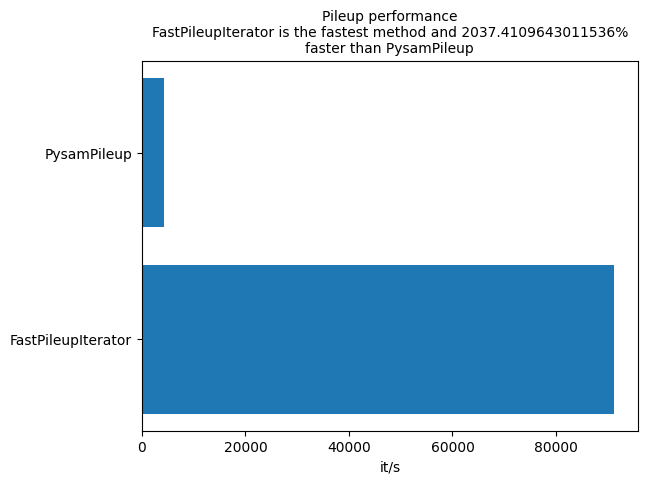

In [32]:
reg=gi('1:22377202-22429853') # the iterated region
times=defaultdict(Counter) # Counter for storing the results. Will contain one GI entry per position which is itself an {allele:count} Counter.

# rnalib pileup
with rna.Timer(times, 'FastPileupIterator') as timer:
    ac1=Counter()
    for loc,dat in tqdm(rna.it(rna.get_resource('small_example_bam'), style='pileup', region=reg)):
        ac1[loc.chromosome, loc.start] = dat
        
# samtools pileup
with rna.Timer(times, 'PysamPileup') as timer:
    ac2=Counter()
    with rna.open_file_obj(rna.get_resource('small_example_bam')) as bam:
        for pu in tqdm(bam.pileup(contig=reg.chromosome, start=reg.start-1, stop=reg.end, 
                                  flag_filter=rna.DEFAULT_FLAG_FILTER, truncate=True, mark_ends=True,
                                  add_indels=True, min_base_quality=0, min_mapping_quality=0,
                                  ignore_overlaps=False, ignore_orphans=False, max_depth=100000)):
            pos=(pu.reference_name, pu.reference_pos+1)
            ac2[pos]=Counter()
            for r in pu.pileups:
                if r.is_refskip:
                    continue
                elif r.is_del:
                    ac2[pos][None]+=1
                else:
                    ac2[pos][r.alignment.query_sequence[r.query_position]]+=1

# PysamPileup will not iterate/report uncovered alignment columns. 
# So, here we add empty Counters for those positions
for p in (ac1.keys() - ac2.keys()):
    ac2[p]=Counter()
          
# now compare the resulting counters
assert ac1==ac2

# plot the times
rna.plot_times('Pileup performance', times, n=len(reg), reference_method='FastPileupIterator')

# show some example columns
rna.head_counter(ac1)

### grouping
A GroupedLocationIterator wraps another LocationIterator and iterates groups of items sharing (parts of) the same location given a matching strategy 
(e.g., same start or end, same coordinates or overlapping). This iterator yields tuples of (merged) group location and a (locations, items) tuple containing lists of locations/items yielded from the wrapped iterator. 

Grouping strategies are 'start' (only start coordinate match), 'end' (end coordinate match), 'both' (complete match; default), 'overlap' (coordinate overlap).

Typically, you would instantiate a grouped location iterator via the `.group()` method, as shown below.

In this example, we simply count how many features in a give GFF file share the same location (e.g., gene and transcript annotations).

In [6]:
lines=[] # for output
with rna.it(rna.get_resource('gencode_gff')).group(strategy='both') as it: # get a grouped GFF iterator
    for bloc, (locs, items) in it:
        if len(items) > 1: # get all locations with more than 1 feature
            lines.append(f"{bloc}: {len(items)} items with feature_types { {i['feature_type'] for i in items}}")  
display_textarea('\n'.join(lines))

### tiling
A common practice of many genomics applications is to break up analyses into continuous blocks (genomic intervals or tiles), e.g., to parallelize computation or just to deal with large datasets. Splitting a reference dict (i.e., a genome representation) into such blocks can easily be done using its `iter_blocks()` method. 
In _rnalib_, a TiledIterator can be used for splitting large datasets into more managable units of data. A TiledIterator wraps another LocationIterator and reports tuples of items yielded for each genomic tile. Iterating over a large BAM file, handling non-overlapping genomic intervals, for example, can be done as shown below.

Typically, you would instantiate this iterator via the `.tile()` method, as shown below.

*Note that you could also use an AnnotationIterator for this task as demonstrated above. In this case the region list must be sorted though!*

In [7]:
with rna.it(rna.get_resource('small_example_bam'), # Create a read iterator
            flag_filter=0, # report all reads
            fun_alias=rna.toggle_chr # add a 'chr' prefix to the chromosome names (via fun_alias) so they match the CANONICAL_CHROMOSOMES dict below
           ).tile() as it: # report tiles 
        # Iterate the alignments and count the number of reads (=length of dat) per tile.
        # Store the results in a dict, but ony for 'canonical' GRCh38 chromosomes
        stats={loc: len(dat) for loc, dat in it if loc.chromosome in rna.CANONICAL_CHROMOSOMES['GRCh38']}
# show first 5 entries of the results dict. There are reads only at the beginning of chromosome 1 in this file.
display(dict(list(stats.items())[0:5]), '...')

{chr1:1-100000000: 31678,
 chr1:100000001-200000000: 0,
 chr1:200000001-249250621: 0,
 chr2:1-100000000: 0,
 chr2:100000001-200000000: 0}

'...'

Here is another example in which we bin data from a begraph file by tiling it into blocks and iterating the respective scores and the locations of the intervals they stem from. 

In [9]:
# show the bedgraph file
rna.print_small_file(rna.get_resource('test_bedgraph'))
display(SEP)

# As we cannot retrieve chromosome lengths from tabix files, we first create a RefDict with `calc_chromlen=True` to estimate chromosome lengths from iterating the file. 
# Then, we can calculate tiles that cover all covered regions. 
refdict = rna.RefDict.load(rna.get_resource('test_bedgraph'), calc_chromlen=True)
with rna.it(rna.get_resource('test_bedgraph'), refdict=refdict) as it:
    # Create a list of non-overlapping intervals (tiles) of size 7 from the iterator's refdict.
    regions = it.refdict.tile(tile_size=7)
    # Iterate the alignments and display the tile interval, the data from the bedgraph file, the respective interval locations and a weighted sum
    with it.tile(regions_iterable=regions) as tit:
        for loc, dat in tit:
            display(f"{loc}: scores: {dat} considered locations: {tit.tile_locations}, sum: {sum([x*loc.overlap(y) for x,y in zip(dat, tit.tile_locations)])}")

track type=bedGraph name='from umap M24' description='umap multi-read mappability of mm10 with k24'
1	0	1	0.0
1	1	2	0.042
1	2	3	0.083
1	3	4	0.125
1	4	5	0.167
1	5	6	0.208
1	6	10	0.3
1	15	17	0.7
1	17	19	0.8
1	20	40	0.1


---

'1:1-7: scores: (0.0, 0.042, 0.083, 0.125, 0.167, 0.208, 0.3) considered locations: (1:1-1, 1:2-2, 1:3-3, 1:4-4, 1:5-5, 1:6-6, 1:7-10), sum: 0.925'

'1:8-14: scores: (0.3,) considered locations: (1:7-10,), sum: 0.8999999999999999'

'1:15-21: scores: (0.7, 0.8, 0.1) considered locations: (1:16-17, 1:18-19, 1:21-40), sum: 3.1'

'1:22-28: scores: (0.1,) considered locations: (1:21-40,), sum: 0.7000000000000001'

'1:29-35: scores: (0.1,) considered locations: (1:21-40,), sum: 0.7000000000000001'

'1:36-40: scores: (0.1,) considered locations: (1:21-40,), sum: 0.5'

# Feature Annotation

Data integration is a central use case for genomic libraries which often requires the annotation of genomic features (e.g., genes or exons) with data derived from other, overlapping genomic intervals. One example is to calculate a mean genomic score based on data associated with all overlapping intervals from one or multiple other dataset(s).

There are many different approaches to achieve these tasks:
- in [pybedtools](https://daler.github.io/pybedtools), which is based on BEDTools, you could:
    - [intersect](https://daler.github.io/pybedtools/autodocs/pybedtools.bedtool.BedTool.intersect.html#pybedtools.bedtool.BedTool.intersect) the respective interval sets
    - apply a custom annotation method via [map()](https://daler.github.io/pybedtools/autodocs/pybedtools.bedtool.BedTool.map.html#pybedtools.bedtool.BedTool.map) or [each()](https://daler.github.io/pybedtools/autodocs/pybedtools.bedtool.BedTool.each.html#pybedtools.bedtool.BedTool.each) method
- In [bioframe](https://bioframe.readthedocs.io/), which is based on pandas dataframes, you could:
    - first use [overlap()](https://bioframe.readthedocs.io/en/latest/guide-intervalops.html#overlap) to intersect the interval sets
    - then group on the annotated feature location using pandas [groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) method
    - and finally apply some [user defined mutate methods](https://pandas.pydata.org/docs/user_guide/gotchas.html#gotchas-udf-mutation) via apply() or aggregate().


_Rnalib_ transcriptomes contain an `anno` dict (a specialized _defaultdict_) for mapping (frozen) features (e.g., genes or exons) to arbitray annotations, e.g., float values, numpy arrays or custom python objects. Annotations can be added manually or by using the `transcriptome.annotate()` method that implements a generic method to add feature-based annotations based on rnalib's [`AnnotationIterator`](#AnnotationIterator) as shown below. The following section demonstrates some use cases:

In [11]:
# First, let's instantiate a small transcriptome that contains only a few human genes (near ACTB and SOX2) 
t = rna.Transcriptome(
    genome_fa=rna.get_resource('ACTB+SOX2_genome'),       # reference genome FASTA
    genome_offsets= {'chr3': 181711825, 'chr7': 5526309}, # This is a sliced reference sequence. To match the gencode annotations we provide respective offset coordinates for the 2 chroms
    annotation_gff=rna.get_resource('gencode_gff'),       # gene annotation GFF
    annotation_flavour='gencode',                         # this is a gencode flavoured GFF
    load_sequence_data=False,                              # load gene sequences from reference genome)
    disable_progressbar=True
)
display(t)

Transcriptome with 5 genes and 89 tx

We can now manually set annotation values and access them via 'dot' notation.

In [12]:
t.anno[t['ACTB']]['test']=(1,2,3) # add a "test" property to gene 'ACTB' and assign a tuple as value
display(t['ACTB'].test) # access the annotation via 'dot' notation

(1, 2, 3)

We can also add arbitrary other features (e.g., a GI representing some regulatory region) to the transcriptomes anno dict.

In [13]:
reg = t.add(gi('chr3:5000-6000'), feature_id='my_reg_region', feature_type='regulatory_region') # create a 'regulatory_region' feature and add to the transcriptome
t.anno[reg]['test']=(4,5,6) # add a 'test' annotation
display(reg.test)

(4, 5, 6)

Note, that features are compared by their feature_id, feature_type and coordinates (see `rna.Feature.key()`).
So, in the following example, reg2 is considered equal to reg, whereas reg3 is a different feature

In [14]:
reg2 = t.add(gi('chr3:5000-6000'), feature_id='my_reg_region', feature_type='regulatory_region') # same region/id!
t.anno[reg2]['test']=(7,8,9) # add a 'test' annotation
assert reg == reg2

reg3 = t.add(gi('chr3:5000-6000'), feature_id='my_reg_region2', feature_type='regulatory_region') # same region but different id
t.anno[reg3]['test']=(10,11,12) # add a 'test' annotation
assert reg != reg3

# show all regulatory regions
[(f, f.feature_id,d) for f,d in  t.iterator(feature_types='regulatory_region')]

[(regulatory_region@chr3:5000-6000, 'my_reg_region', {'test': (7, 8, 9)}),
 (regulatory_region@chr3:5000-6000, 'my_reg_region2', {'test': (10, 11, 12)})]

We can also serialize a subset of features (here: all regulatory_regions) to a GFF3 file

In [15]:
with tempfile.TemporaryDirectory() as tmp:
    gff3file = os.path.join(tmp, 'transcriptome.gff3')
    t.to_gff3(gff3file, bgzip=True, feature_types=('regulatory_region')) # write to temporary GFF3 file
    rna.print_small_file(gff3file + '.gz', show_linenumber=True)

line 1: chr3	rnalib	regulatory_region	5000	6000	.	.	.	ID=my_reg_region
line 2: chr3	rnalib	regulatory_region	5000	6000	.	.	.	ID=my_reg_region2


In principle, arbitrary features can be added to a transcriptome as long as they inherit from the `rna.Feature` class. 
Note, however, that the `transcriptome` implementation treats 'gene' and 'transcript' features in a special way (see implementation), 
so be careful to not break things when adding annotations of this types.

## AnnotationIterator

`rnalib` contains a special LocationIterator called `AnnotationIterator` for annotating genomic intervals with data from one or *multiple* other genomic location iterators.
This iterator synchronizes genomic locations of the primary iterator (iterating the intervals to be annotated) with all annotating iterators and yields respective locations and data for all overlapping intervals. In the example below, we iterate over annotations in a genomic subregion of a flybase GTF file and annotate all features with  (i) a list of SNPs that were called in 3 particular samples of a multi-sample VCF file and (ii) values from bedgraph file.

**Note** that iterating over large interval sets is generally considered slow and is often not needed. 
In many cases you can use list [comprehension, vectorisation](https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-pandas-dataframe/)
or mechanisms such as [pandas apply()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) or [pybedtools each()](https://daler.github.io/pybedtools/each.html) as described above. 
Nevertheless, there are scenarios in which we consider AnnotationIterators  useful, e.g., if you need to access to contextual data (e.g., annotation results from previous data rows) or if you need (fine-grained) access to multiple synchronized datasets in parallel. Performance drawbacks of iteration approaches are also diminished when integrating multiple iterators in parallel. The overall goal of AnnotationIterators is to improve code readability and reduce potential error sources such as [the ones discussed in the 'RelatedWork' notebook](RelatedWork_performance.ipynb#Potential-pifalls). AnnotationIterators are also used by rnalib's [`transcriptome.annotate()`](#Annotation-of-features) method for incremental transcriptome annotation as shown below.

In [16]:
# Annotate flybase GTF annotation with (i) a list of the genotypes of overlapping SNPs for 
# 3 samples and (ii) the maximum value from a bedgraph track
with rna.it(
    rna.it(rna.get_resource('flybase_gtf'), 
           region='2L:1-30000'), # iterate over 2L:1-30000 in the flybase GTF
           anno_its =[ rna.it(rna.get_resource('dmel_multisample_vcf'), # annotate with overlapping SNPs but consider 3 samples only
                              samples=['DGRP-208', 'DGRP-325', 'DGRP-721']),
                      rna.it(rna.get_resource('dmel_randomvalues')) ], # annotate with a bedgraph file
    disable_progressbar=True) as it:
    for loc, (gff_feature, overlapping_snps, rand_values) in it.to_list()[:5]: # here we show just the first 5 features...
        # Remember that rnalib iterators return named (location, data) tuples. Here, 'snps' is a list of such 
        # items and we can access the respective VCFRecord objects via the data field:
        overlapping_snps=[x.data for x in overlapping_snps]
        # rand_values is a sorted list (by genomic location) of overlapping values from the Bedgraph file.
        # We use min/max to get the first/last items from this list and access the value via the 
        # data field and convert from float (as returned by the bedgraph iterator) to int:        
        tp_value, fp_value = int(min(rand_values).data), int(max(rand_values).data) 
        # now we can display some data
        display(f"{gff_feature['feature_type']}@{loc} {gff_feature.get('transcript_id','NA')} (gene {gff_feature['gene_symbol']})")
        display(f"SNPs: {overlapping_snps}")
        display(f"3'-value: {tp_value}, 5'-value: {fp_value}", SEP)

'gene@2L:7529-9484 (+) NA (gene CR11023)'

'SNPs: [2L:7556T>C, 2L:7902A>G, 2L:8124A>C, 2L:8263G>A, 2L:9204T>C]'

"3'-value: 870, 5'-value: 319"

---

'pseudogene@2L:7529-9484 (+) FBtr0475186 (gene CR11023)'

'SNPs: [2L:7556T>C, 2L:7902A>G, 2L:8124A>C, 2L:8263G>A, 2L:9204T>C]'

"3'-value: 870, 5'-value: 319"

---

'exon@2L:7529-8116 (+) FBtr0475186 (gene CR11023)'

'SNPs: [2L:7556T>C, 2L:7902A>G]'

"3'-value: 870, 5'-value: 146"

---

'exon@2L:8193-9484 (+) FBtr0475186 (gene CR11023)'

'SNPs: [2L:8263G>A, 2L:9204T>C]'

"3'-value: 622, 5'-value: 319"

---

'exon@2L:9839-11344 (-) FBtr0078171 (gene l(2)gl)'

'SNPs: [2L:10018G>A, 2L:10089G>A, 2L:10610G>T]'

"3'-value: 932, 5'-value: 856"

---

Here is another example in which we simply annotate intervals from a BED file with the sum of scores or all overlapping intervals from a bedgraph file.
As all rnalib `LocationIterators` yield their current genomic interval in a uniform format, it is straightforward to use interval arithmetic in the annotation method (in this example we calculate the overlap fraction to calculate the actual score contributions of overlapping bedgraph intervals).

In [17]:
# Annotate all intervals in a BED file with sum of scores from a bedgraph file; 
# supports bedgraph intervals >1bp: 
# score contribution is calculated from the interval overlap (this bedgraph file contains, e.g., an interval (1:7-10, 0.3))
print('rnalib annotation iterator wrapping a Bed- and a BedGraphiterator')
with rna.it(rna.it(rna.get_resource('test_bed')), 
            anno_its=rna.it(rna.get_resource('test_bedgraph')), 
            labels=['scores'], 
            disable_progressbar=True) as it:
    for loc, i in it:
        display(f"Annotation {i.anno}, sum:{sum([x.data*loc.overlap(x.location) for x in i.scores])}")
    display(it.stats())  

rnalib annotation iterator wrapping a Bed- and a BedGraphiterator


'Annotation 1:6-10 (int1), sum:1.408'

'Annotation 1:10-15 (int2), sum:0.3'

'Annotation 2:10-150 (int3), sum:0'

Counter({('yielded_items', '1'): 2, ('yielded_items', '2'): 1})

Here we repeat this code block, but this time we tell `it()` to create `PybedtoolsIterator`s that wrap a _pybedtools_ _BedTool_.
Note the slight differences. The returned data is now a _pybedtools_ item, access to the bedgraph score is via the name attribute (but its a string, so we need to convert to float). 

In [18]:
# Same as above, just for demonstration purposes, but now using pybedtools iterators that wrap a pybedtools BedTool
print('rnalib annotation iterator wrapping two PybedtoolsIterators')
with rna.it(rna.it(rna.get_resource('test_bed'), style='pybedtools'), 
            anno_its=rna.it(rna.get_resource('test_bedgraph'), style='pybedtools'), 
            labels=['scores'], disable_progressbar=True) as it:
    for loc, i in it:
        # Note the slight differences. The returned data is now a pybedtools item, access to the 
        # bedgraph score is via the name attribute (but its a string, so we need to convert to float). 
        display(f"Annotation {i.anno}, sum:{sum([float(x.data.name)*loc.overlap(x.location) for x in i.scores])}")
    display(it.stats())

rnalib annotation iterator wrapping two PybedtoolsIterators
RefDict (size: 2): dict_keys(['1', '2']), dict_values([None, None]) name: References from TABIX file b'rnalib_testdata//bed/test.bed.gz' 
RefDict (size: 1): dict_keys(['1']), dict_values([None]) name: References from TABIX file b'rnalib_testdata//bed/test.bedgraph.gz' 


'Annotation 1\t5\t10\tint1\n, sum:1.408'

'Annotation 1\t9\t15\tint2\n, sum:0.3'

'Annotation 2\t9\t150\tint3\n, sum:0'

Counter({('yielded_items', '1'): 2, ('yielded_items', '2'): 1})

## Transcriptome annotate function
`rnalib` transcriptomes contain an `annotate()` method that creates a `TranscriptomeIterator` over its features and annotates it with a list of LocationIterators, applying the custom `fun()` method as demonstrated in this example:

In [19]:
# Now, lets annotate exons and introns with mappability scores that are read from a bedgraph file.
# We first create a method for calculating the mean mappability for an annotation based on the scores of
# all overlapping intervals from the bedgraph file.
def calc_mean(item, label='mappability'):
    loc, (anno, scores) = item
    anno[label]=sum([score*loc.overlap(sloc) for sloc,score in scores])/len(loc)
    return calc_mean

# now we can call the annotate method, tell it to get the scores from a bedgraph iterator and
# to annotate only exons + introns. Note that this test bedgraph file covers only ~half of ACTB,
# (use a genome  browser like IGV to confirm this). So the mappability of the uncovered regions will 
# be set to zero.
t.annotate(anno_its=rna.it(rna.get_resource('human_umap_k24')),
           fun_anno=calc_mean,
           feature_types=['exon', 'intron'])

  0%|          | 0/2 [00:00<?, ?it/s]

Now we can access the annotated data:

---

'Mappability for a random ACTB transcript:'

[(1, 'ENST00000484841.6_exon_4', 0.974448717948718),
 (2, 'ENST00000484841.6_exon_3', 0.8795778894472361),
 (3, 'ENST00000484841.6_exon_2', 0.28020416666666664),
 (4, 'ENST00000484841.6_exon_1', 1.0),
 (5, 'ENST00000484841.6_exon_0', 0.0)]

---

'Some annotated values:'

'exon mappability value: 0.9702537313432836'

'gene mappability value: None'

---

"Dataframe representation, filtered for gene_type=='protein_coding' & mappability>0"

,Chromosome,Start,End,Strand,feature_id,feature_type,test,mappability,gff_feature_type,gene_name,source,gene_type
119,chr7,5527784,5529570,-,ENST00000676319.1_intron_0,intron,None,0.373112,exon,None,HAVANA,protein_coding
203,chr7,5528281,5529059,-,ENST00000477812.2_exon_2,exon,None,0.432606,exon,None,HAVANA,protein_coding
204,chr7,5528281,5529400,-,ENST00000462494.5_exon_2,exon,None,0.451115,exon,None,HAVANA,protein_coding


---

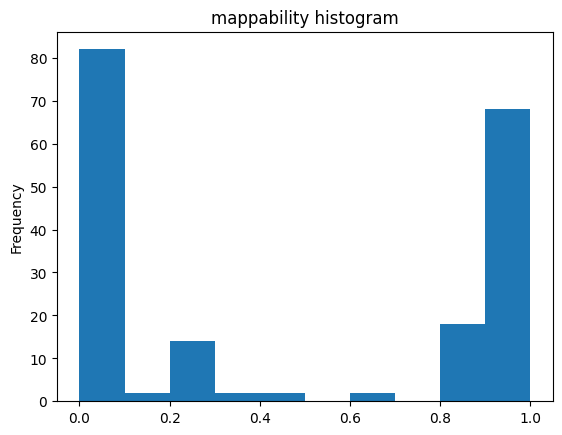

In [20]:
# Now, lets show the mappability values for exons and introns of one random transcript 
rnd_tx = random.sample(t.gene['ACTB'].transcript, 1)[0]
display(SEP, "Mappability for a random ACTB transcript:", [(f.rnk, f.feature_id, f.mappability) for f in rnd_tx.exon])
# Note that it would be more efficient to annotate genes with mappability score arrays and then calculate mean/median mappability
# for each feature by slicing these arrays (as done, e.g., for sequences) but this is omitted here for the sake of simplicity


# Its recommended to use get/getattr to provide sensible default values for missing data:
display(SEP, "Some annotated values:")
display(f"exon mappability value: {t['ENST00000477812.2'].exon[0].get('mappability',None)}") # show some mappability value
display(f"gene mappability value: {t['ACTB'].get('mappability',None)}") # only exons/introns were annotated above

# We can also convert results to a dataframe (but note that we lose the parent/child relationships here).
df = t.iterator().to_dataframe()
# let's use the pandas query method to show features from protein_coding genes with non-zero mappability...
display(SEP, "Dataframe representation, filtered for gene_type=='protein_coding' & mappability>0", 
        df.query('gene_type=="protein_coding" & mappability>0').head(3),SEP)
# ...and plot the overall mappability distribution...
_ = df['mappability'].plot(kind='hist', title='mappability histogram')

In this second example, we calculate the number of overlapping introns per exon with a custom annotation function and plot the results:

  0%|          | 0/2 [00:00<?, ?it/s]

"Example exon@chr7:5529067-5529663 with 33 overlapping introns: {'ENST00000645576.1_intron_1', 'ENST00000477812.2_intron_2', 'ENST00000473257.3_intron_3', 'ENST00000425660.5_intron_3', 'ENST00000676397.1_intron_3', 'ENST00000432588.6_intron_2', 'ENST00000414620.1_intron_0', 'ENST00000647275.1_intron_1', 'ENST00000674681.1_intron_3', 'ENST00000645025.1_intron_1', 'ENST00000642480.2_intron_3', 'ENST00000675515.1_intron_2', 'ENST00000425660.5_intron_4', 'ENST00000473257.3_intron_2', 'ENST00000674681.1_intron_2', 'ENST00000645576.1_intron_2', 'ENST00000646664.1_intron_3', 'ENST00000676189.1_intron_2', 'ENST00000484841.6_intron_1', 'ENST00000462494.5_intron_2', 'ENST00000675515.1_intron_3', 'ENST00000676397.1_intron_2', 'ENST00000432588.6_intron_1', 'ENST00000646664.1_intron_2', 'ENST00000645025.1_intron_0', 'ENST00000676189.1_intron_3', 'ENST00000493945.6_intron_2', 'ENST00000642480.2_intron_2', 'ENST00000484841.6_intron_2', 'ENST00000443528.5_intron_0', 'ENST00000676319.1_intron_0', 'ENST

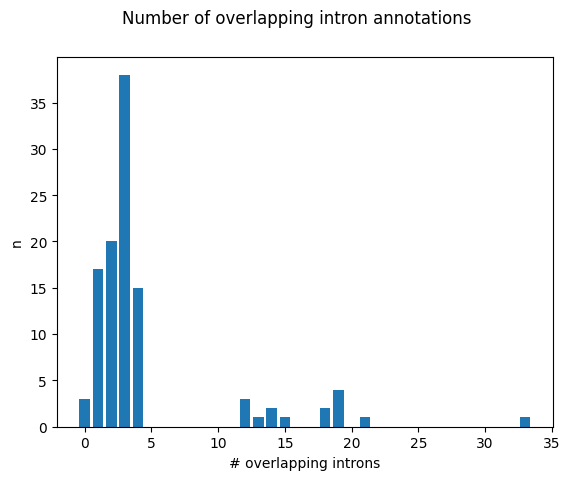

In [21]:
# Here we calculate the number of overlapping introns per exon.
def count_anno(item):
    loc, (anno, overlapping) = item
    # Here we simply count the number of overlapping intron annotations but we could also group
    # by tx or gene, etc.
    anno['n_overlapping_introns']=len(overlapping)
    anno['overlapping_introns']=overlapping

# now we can call the annotate method for all exons of this transcriptome and tell it to 
# annotate with all introns of this transcriptome. In the passed annotation method (count_anno) we 
# simply count the number of overlapping annotations (introns).
# Its easy to check in IGV (loading the GFF3 file) whether the numbers are correct.
t.clear_annotations() # make sure to remove previously added annotations
t.annotate(anno_its=rna.it(t, feature_types=['intron']),
           fun_anno=count_anno,
           feature_types=['exon'])

# Here we create a histogram ...
intron_hist=Counter()
for ex,_ in t.iterator(feature_types=['exon']):
    intron_hist[ex.n_overlapping_introns]+=1

# ... and plot it
x, y = zip(*intron_hist.items())
_=plt.bar(x,y)
plt.xlabel("# overlapping introns")
plt.ylabel("n")
_=plt.suptitle("Number of overlapping intron annotations")

# Here we show one example with max number of overlapping introns
# NOTE that there can be multiple introns per transcript that overlap with a given exon.
for ex,info in rna.it(t,feature_types=['exon']):
    if info.get('n_overlapping_introns', 0)==max(intron_hist):
        tids = {i.parent.feature_id for i,_ in info['overlapping_introns']}
        display(f"Example {ex} with {info['n_overlapping_introns']} overlapping introns: { {i.feature_id for i,_ in info['overlapping_introns']} }, tids: {tids}")
        break    

# Conversion to a dataframe
Finally, we can convert any LocationIterator to a dataframe for further analysis with pandas and pandas-based libraries (e.g., bioframe as demonstrated below).
The to_dataframe() method consumes all items of an iterator and supports the flexible construction of such dataframes.
Here, we first create a simple dataframe from a TranscriptomeIterator. The resulting dataframe contains all 'regulatory_regions' features that we added above.

In [22]:
# Create a df of all regulatory region features
df = rna.it(t, feature_types='regulatory_regions').to_dataframe()
df.head()

,Chromosome,Start,End,Strand,feature_id,feature_type,overlapping_introns,n_overlapping_introns,gff_feature_type,gene_name,source,gene_type
0,chr3,5000,6000,.,my_reg_region,regulatory_region,None,None,None,None,None,None
1,chr3,5000,6000,.,my_reg_region2,regulatory_region,None,None,None,None,None,None


Note that cell above would fail if you set feature_types='exon' as the dataframe could not be printed. Ths is, because the 'overlapping_introns' 
annotation we added above contains lists of Fetaure objects that cannot be serialized as strings automatically. 
We can print the dataframe w/o this column though:

In [38]:
# Create a df of all exon features
df = rna.it(t, feature_types='exon').to_dataframe()
df.drop(columns=['overlapping_introns']).head()

,Chromosome,Start,End,Strand,feature_id,feature_type,n_overlapping_introns,gff_feature_type,gene_name,source,gene_type
0,chr3,181711925,181714436,+,ENST00000325404.3_exon_0,exon,0,exon,None,HAVANA,protein_coding
1,chr7,5526409,5527891,-,ENST00000674681.1_exon_0,exon,3,exon,None,HAVANA,protein_coding
2,chr7,5527147,5527783,-,ENST00000676319.1_exon_0,exon,1,exon,None,HAVANA,protein_coding
3,chr7,5527147,5527867,-,ENST00000676397.1_exon_0,exon,2,exon,None,HAVANA,protein_coding
4,chr7,5527147,5527891,-,ENST00000642480.2_exon_0,exon,3,exon,None,HAVANA,protein_coding


We can also provide a *custom conversion function* that adds additional data columns or aggregates existing ones.
In the following example, we iterate over all exons and add custom data columns to the created dataframe:
* we calculate a 'feature length' from the exon interval and add a new 'feature_len' columns
* we retrieve the 'gene_name' via the transcriptome model and fill the respective column
* we convert the previously annotated 'overlapping_introns' list to a comma-separated string that can be printed
 
Finally, we add the new columns to the dataframe and drop some other columns we do not need. We also use bioframe-compatible column names for genomic coordinates which enables direct post-processing with the bioframe library.

In [39]:
# Convert to pandas dataframe with a custom conversion function:
def my_fun(loc, item, fun_col, default_value): 
    ret=list()
    for col in fun_col:
        if col=='feature_len':
            ret.append(len(loc)) # add 'feature_len' column; note that this column must also be added to the output dataframe via 'included_columns' as shown below
        elif col=='gene_name':
            ret.append(loc.parent.parent.gene_name) # retrieve gene name via parent/child relationships
        elif col=='overlapping_introns':
            ret.append(','.join([str(x.location.feature_id) for x in loc.get(col, default_value)])) # create comma-separated string of intron ids
        else:
            ret.append(loc.get(col, default_value)) # for all other columns, get annotation from the feature directly.
    return ret

df = rna.it(t, feature_types='exon').to_dataframe( \
         fun=my_fun, # passes our annotation function
         included_columns=('feature_len',), # include our new column
         excluded_columns=('dna_seq', 'source', 'gff_feature_type', 'feature_id'), # columns that are dropped
         coord_colnames=('chrom', 'start', 'end', 'strand'), # use bioframe-compatible column names
         default_value='NA'
        )

df.head(3)  # report max 3 items

,chrom,start,end,strand,feature_type,overlapping_introns,n_overlapping_introns,gene_name,gene_type,feature_len
0,chr3,181711925,181714436,+,exon,,0,SOX2,protein_coding,2512
1,chr7,5526409,5527891,-,exon,"ENST00000464611.1_intron_0,ENST00000676319.1_i...",3,ACTB,protein_coding,1483
2,chr7,5527147,5527783,-,exon,ENST00000464611.1_intron_0,1,ACTB,protein_coding,637


So now, we can use bioframe to merge the intervals and use pandas to plot a histogram of the overlap counts

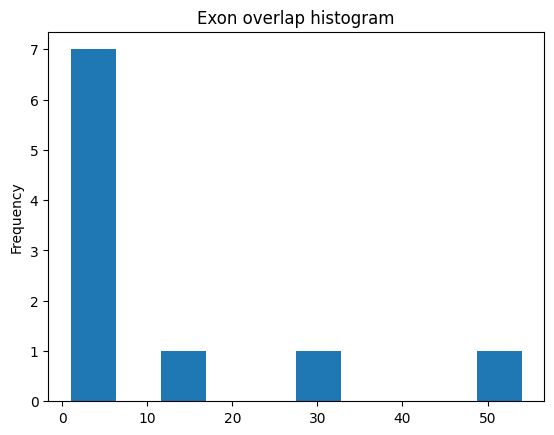

In [40]:
_ = bioframe.merge(df)['n_intervals'].plot.hist(title='Exon overlap histogram')

We can also 'describe' a dataset which converts it to a pandas dataframe and calls df.describe().
Additionally it calculates some stats such as whether this dataset contains overlapping or empty intervals.

In [41]:
df, stats = rna.it(t, feature_types='exon').describe(fun=my_fun)
display(df.head(5))
display(stats)

,Chromosome,Start,End,Strand,feature_id,feature_type,overlapping_introns,n_overlapping_introns,gff_feature_type,gene_name,source,gene_type
count,108,1.080000e+02,1.080000e+02,108,108,108,108,108.000000,108,108,108,108
unique,2,NaN,NaN,2,108,1,28,NaN,1,4,1,3
top,chr7,NaN,NaN,-,ENST00000325404.3_exon_0,exon,"ENST00000414620.1_intron_1,ENST00000443528.5_i...",NaN,exon,ACTB,HAVANA,protein_coding
freq,107,NaN,NaN,105,1,108,15,NaN,108,105,108,106
mean,NaN,7.162412e+06,7.162717e+06,NaN,NaN,NaN,NaN,4.527778,NaN,NaN,NaN,NaN


{'contains_overlapping': True, 'contains_empty': False}

Here, for example, we iterate over the first 100 reads of a BAM file and collect some summary statistics for the 
NM (number of mismatches) and NH (number of hits) tags

In [42]:
df, stats = rna.it(rna.get_resource('small_example_bam')).describe(\
         # custom column creation; Note that 'item' is a pysam read object in this case
         fun=lambda loc, item, fun_col, default_value:[item.get_tag(col) for col in fun_col] , \
         fun_col=('NM', 'NH'), # include our new columns: NM (number of mismatches) and NH (number of hits)
         max_items=100) # report max 100 items. The iterator will stop after this.
display(df.head(5))
display(stats)

,Chromosome,Start,End,Strand,NM,NH
count,100,100.00,100.0,100,100.00,100.00
unique,1,NaN,NaN,2,NaN,NaN
top,1,NaN,NaN,+,NaN,NaN
freq,100,NaN,NaN,78,NaN,NaN
mean,NaN,22379157.79,22403099.2,NaN,0.66,1.02


{'contains_overlapping': True, 'contains_empty': False}

This concludes our introduction to _rnalib_'s API. 
Please refer to our other notebooks for application scenarios of _rnalib_ and to the test cases for more usage examples.

# Utility functions

_rnalib_ also contains a number of utility functions which might be useful for handling genomics data. Some of those functions were demonstrated already in the context of this notebook. Here we present and document some of those in more detail:

In [28]:
# Gene symbols are updated regularly and mapping between different id schemas is cumbersome
# rnalib implements an interface to MyGeneInfo for easy translation between ids and symbols 
# Example: we pass a mixed list of Ensembl and Entrez ids for mouse and human  actin beta:
rna.geneid2symbol(['ENSMUSG00000029580', 60])

INFO:biothings.client:querying 1-2...
INFO:biothings.client:done.


{'ENSMUSG00000029580': Actb (actin, beta, tax: 10090),
 '60': ACTB (actin beta, tax: 9606)}

In [43]:
# Another possibility is to use alias files that provide a mapping from previous (outdated) to current gene symbols.
# rnalib supports such alias files and here we showcase this by loading a small subset of genenames.org data 
# and using it to convert lists containing partially old gene symbols to their current symbol.
aliases, current_symbols = rna.read_alias_file(rna.get_resource('hgnc_gene_aliases'))
# now lets translate some gene symbols
display(rna.norm_gn('A2MP', current_symbols, aliases), 
        rna.norm_gn('FLJ23569', current_symbols, aliases),
        rna.norm_gn('A2MP1', current_symbols, aliases)) 
# Please note that the transcriptome implementation has implicit support for gene name aliasing, all you need to do is to pass a file path refering to a
# genenames.org like file via the 'gene_name_alias_file' config property.

load gene aliases:   0%|          | 0/9 [00:00<?, ?it/s]

'A2MP1'

'A1BG-AS1'

'A2MP1'

In [44]:
# A convenience method for working with BAM files is the get_covered_contigs() method that accesses a BAM index and quickly calculates which contigs contain reads:
rna.get_covered_contigs(rna.get_resource('small_example_bam'))

{'1'}

In [45]:
# Rnalib also contains a growing number of utilities to work with Nanopore data (FAST5 files)
# You can, e.g., inspect the structure of such a file:
fast5_file=rna.get_resource('nanoseq_fast5_raw')
rna.print_fast5_tree(fast5_file, show_attrs=False)

Raw └── Reads
Raw     └── Read_205344 {duration=21211,median_before=217.6046905517578,read_id=b'003c04de-f704-491e-8d0c-33ffa269423d',read_number=205344,start_mux=4,start_time=364905104}
Raw         └── Signal
---


In [46]:
# Or list the basecalling groups in this file
fast5_file=rna.get_resource('nanoseq_fast5_basecalled')#'testdata/fast5/FAT61995_a1291c8f_5.fast5'
rna.get_bcgs(fast5_file)

['Basecall_1D_000']

'Supported distributions: beta,binomial,bit_generator,bytes,chisquare,choice,dirichlet,exponential,f,gamma,geometric,gumbel,hypergeometric,integers,laplace,logistic,lognormal,logseries,multinomial,multivariate_hypergeometric,multivariate_normal,negative_binomial,noncentral_chisquare,noncentral_f,normal,pareto,permutation,permuted,poisson,power,random,rayleigh,shuffle,spawn,standard_cauchy,standard_exponential,standard_gamma,standard_normal,standard_t,triangular,uniform,vonmises,wald,weibull,zipf'

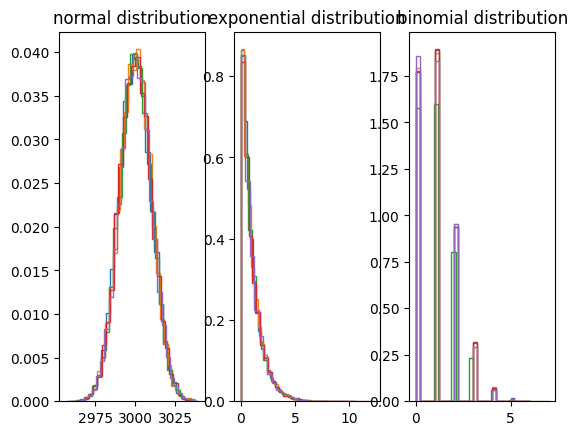

In [47]:
# the random_sample() method can be used to draw samples from a given distribution with numpy.
# Here we draw 5 samples with 10k values each from a normal, an exponential and a binomial distribution and plot the histograms with matplotlib
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (20,3)
# plot 5 histograms of a normal distribution (10k values each)
for x in rna.random_sample('normal(3000,10,size=(5,10000))'):
    ax1.hist(x, 30, density=True, histtype=u'step') # plot 5 histograms
    ax1.set_title('normal distribution')
for x in rna.random_sample('standard_exponential(size=(5,10000))'):
    ax2.hist(x, 30, density=True, histtype=u'step') # plot 5 histograms
    ax2.set_title('exponential distribution')
for x in rna.random_sample('binomial(20, 0.05, size=(5,10000))'):
    ax3.hist(x, 30, density=True, histtype=u'step') # plot 5 histograms
    ax3.set_title('binomial distribution')
# show the supported distributions from numpy
display(f"Supported distributions: {','.join([x for x in dir(np.random.default_rng()) if not x.startswith("_")])}")

Please refer to the test_utils.py script for usage scenarios of other rnalib utility methods.